In [1]:
import os
from os.path import isfile, join

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
import torch.optim as optim

from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset

import pytorch_lightning as pl

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision import models

from colour import Color

from tqdm import tqdm

from PIL import Image

import cv2

In [2]:
import warnings

warnings.filterwarnings("ignore")

Below we will implement our U-net-like network, will fit it and solve the problem of semantic segmentation (Recognition of exact mask of a car in a picture) with help of it.

In [3]:
import math

import glob

import albumentations as A
from albumentations.pytorch import ToTensorV2

In [4]:
class SegmentationDataset(torch.utils.data.Dataset):
    def __init__(self, image_path, mask_path, transforms):
        self.images = glob.glob(os.path.join(image_path, "*.jpg"))
        self.image_path = image_path
        self.mask_path = mask_path
        self.transforms = transforms
        
    def __getitem__(self, idx):
        img = np.array(Image.open(self.images[idx]).convert("RGB"))
        mask = np.array(
            Image.open(
                os.path.join(
                    self.mask_path,
                    os.path.basename(self.images[idx]).replace(".jpg", "_mask.gif"),
                )
            )
        )
        
        mask[mask == 255.0] = 1.0
        augmentations = self.transforms(image=img, mask=mask)
        image = augmentations["image"]
        mask = augmentations["mask"]
        mask = torch.unsqueeze(mask, 0)
        mask = mask.type(torch.float32)
        return image, mask
    
    def __len__(self):
        return len(self.images)

Downloading dataset with help of class above

In [5]:
data = SegmentationDataset(
    image_path='./train',
    mask_path='./train_masks',
    transforms=A.Compose([
    A.Resize(height=256, width=256),
    A.pytorch.ToTensorV2()])
)

train_size = 0.9
train_len = math.floor(len(data) * train_size)
val_len = len(data) - train_len

train_dataset, val_dataset = torch.utils.data.random_split(data, [train_len, val_len])

train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset, batch_size=8, shuffle=True, pin_memory=True, num_workers=0 #3 # 0 because jupyter can't deal with multiprocessing module
)

val_loader = torch.utils.data.DataLoader(
    dataset=val_dataset, batch_size=8, shuffle=True, pin_memory=True, num_workers=0 #3 # 0 because jupyter can't deal with multiprocessing module
)

Let's see some examples of images 

In [6]:
def im_show(img_list):
    '''
    This function recieves a list of images and plots them together
    This function has void type, i.e. return: None
    '''
    to_PIL = transforms.ToPILImage()
    if len(img_list) > 9:
        raise Exception('len(img_list) must be smaller than 10')
    
    for (idx, img) in enumerate(img_list):
        '''
        Когда вы используете enumerate(), функция возвращает две переменные цикла: номер текущей итераций (idx) и 
        значение элемента на контроле итерации (img).
        Поэтому нужно использовать два счетчика цикла при использовании enumerate(). 
        '''
        
        img = np.array(to_PIL(img))
        plt.figure(figsize=(4, 4))
        fig = plt.imshow(img)
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)
        plt.show()

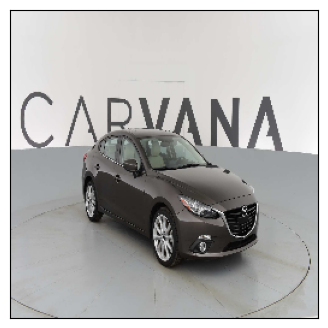

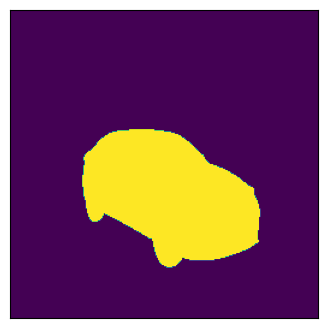

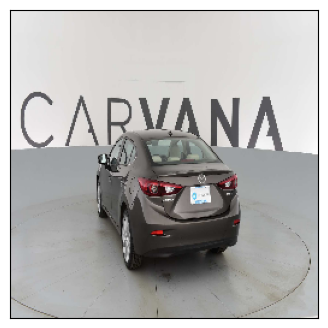

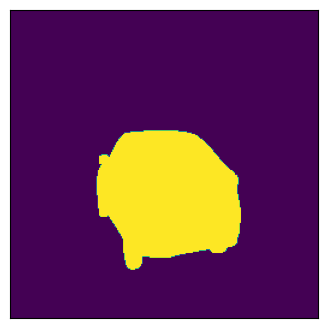

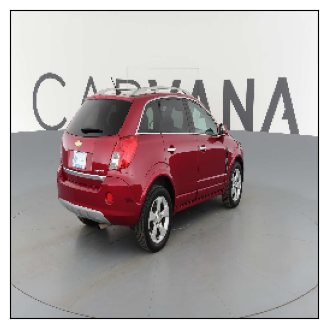

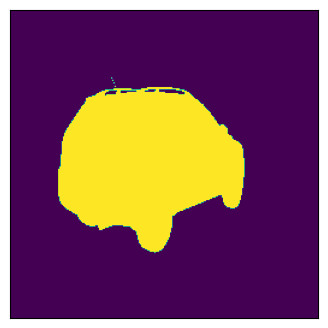

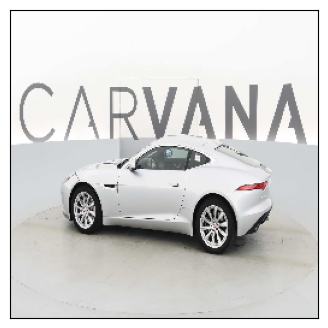

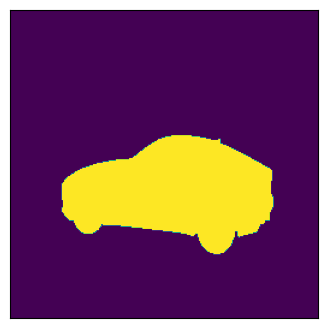

In [7]:
img_list = []
for i in range(4):
    img, label = data[np.random.randint(0, 100)]
    img_list.append(img)
    img_list.append(label)

im_show(img_list)

### Original U-net architecture.

![U-net](https://production-media.paperswithcode.com/methods/Screen_Shot_2020-07-07_at_9.08.00_PM_rpNArED.png)

### Our inplementation will be a little bit different

*Hint*: each block to "down" it is double convolution with batch normalization and activation function (when create ReLU don't forget add inplace=True)

In our implementation we start from 16 channels, not from 64. Also while going down we will achive 128 channels (although in original paper authors achived 1024 channels - we save training time) and use 2 blocks instead of 4. 

In [8]:
# Implementation of single convolution block
class ConvBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, kernel_size=3, padding=1, stride=1):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=padding, stride=stride, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, padding=padding, stride=stride, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )
        
    def forward(self, x):
        return self.conv(x)
    

class U_net(pl.LightningModule):
    def __init__(
        self,
        in_channels: int = 3,
        out_channels: int = 1,
        features: list = [32, 64, 128],
        learning_rate=1.5e-3,
    ):
        super().__init__()
        self.learning_rate = learning_rate
        self.down = nn.ModuleList()
        self.up = nn.ModuleList()
        self.pool = nn.MaxPool2d(2, 2)
        
        for feature in features:
            self.down.append(ConvBlock(in_channels=in_channels, out_channels=feature))
            in_channels = feature
        for feature in reversed(features):
            self.up.append(
                nn.ConvTranspose2d(
                    in_channels=feature * 2,
                    out_channels=feature,
                    kernel_size=2,
                    stride=2.
                )
            )
            self.up.append(
                ConvBlock(
                    in_channels=feature*2, out_channels=feature
                    # x gets concat to 2xchannel
                )
            )
        self.bottleneck = ConvBlock(
            in_channels=features[-1], out_channels=features[-1]*2
        )
        self.final_conv = nn.Conv2d(
            in_channels=features[0], out_channels=out_channels, kernel_size=1
        )
            
        self.loss_fn = nn.BCEWithLogitsLoss()
        self.optimizer = torch.optim.AdamW(
            self.parameters(), lr=self.learning_rate, weight_decay=0.3
        )
        
        self.val_num_correct = 0
        self.val_num_pixels = 0
        self.val_dice_score = 0
        self.num_correct = 0
        self.num_pixels = 0
        self.dice_score = 0
    
    def forward(self, x):
        skip_connections = [] # storage for skip connections
        for down in self.down:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)
        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1] # reverse list
        for idx in range(0, len(self.up), 2):
            skip_connection = skip_connections[idx // 2]
            if x.shape != skip_connection.shape:
                x.transforms.functional.resize(x, size=skip_connection.shape[2:])
            concat_skip = torch.cat(
                (skip_connection, x), dim=1
            ) # concat along channels (b, c, h, w)
            x = self.up[idx + 1](concat_skip)
        return self.final_conv(x)
    
    def configure_optimizers(self):
        return self.optimizer
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        pred = self(x.float())
        loss = self.loss_fn(pred, y)
        pred = torch.sigmoid(pred)
        pred = (pred > 0.5).float()
        
        self.num_correct += (pred == y).sum()
        self.num_pixels += torch.numel(pred)
        self.dice_score += (2 * (pred*y).sum()) / ((pred + y).sum() + 1e-8)
        self.log("train_loss:", loss, prog_bar=True)
        
        return {"loss": loss}
    
    def on_training_epoch_end(self, output):
        train_acc = float(f'{(self.num_correct/self.num_pixels)*100:.2f}')
        self.log("train_acc:", train_acc, prog_bar=True)
        dice_score = self.dice_score / len(output)
        self.log("train_dice_score", dice_score, prog_bar=True)
        self.num_correct, self.num_pixels, self.dice_score = 0, 0, 0
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        pred = self(x.float())
        loss = self.loss_fn(pred, y)
        pred = torch.sigmoid(pred)
        pred = (pred > 0.5).float()
        
        self.val_num_correct += (pred == y).sum()
        self.val_num_pixels += torch.numel(pred)
        self.val_dice_score += (2 * (pred*y).sum()) / ((pred + y).sum() + 1e-8)
        self.log("val_loss:", loss, prog_bar=True)
        
        return {"loss": loss}
    
    def on_validation_epoch_end(self, output):
        train_acc = float(f'{(self.val_num_correct/self.val_num_pixels)*100:.2f}')
        self.log("val_acc:", val_acc, prog_bar=True)
        dice_score = self.val_dice_score / len(output)
        self.log("val_dice_score", val_dice_score, prog_bar=True)
        self.val_num_correct, self.val_num_pixels, self.val_dice_score = 0, 0, 0

Let's take a look on the model configuration if the end

In [9]:
pl.utilities.model_summary.summarize(U_net(), -1)

   | Name              | Type              | Params
---------------------------------------------------------
0  | down              | ModuleList        | 287 K 
1  | down.0            | ConvBlock         | 10.2 K
2  | down.0.conv       | Sequential        | 10.2 K
3  | down.0.conv.0     | Conv2d            | 864   
4  | down.0.conv.1     | BatchNorm2d       | 64    
5  | down.0.conv.2     | ReLU              | 0     
6  | down.0.conv.3     | Conv2d            | 9.2 K 
7  | down.0.conv.4     | BatchNorm2d       | 64    
8  | down.0.conv.5     | ReLU              | 0     
9  | down.1            | ConvBlock         | 55.6 K
10 | down.1.conv       | Sequential        | 55.6 K
11 | down.1.conv.0     | Conv2d            | 18.4 K
12 | down.1.conv.1     | BatchNorm2d       | 128   
13 | down.1.conv.2     | ReLU              | 0     
14 | down.1.conv.3     | Conv2d            | 36.9 K
15 | down.1.conv.4     | BatchNorm2d       | 128   
16 | down.1.conv.5     | ReLU              | 0     
17 | d

###  Model training

In [ ]:
torch.cuda.empty_cache()
model = U_net()

trainer = pl.Trainer(
    max_epochs=2,
    accelerator='gpu'
)
trainer.fit(model, train_loader, val_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name       | Type              | Params
-------------------------------------------------
0 | down       | ModuleList        | 287 K 
1 | up         | ModuleList        | 753 K 
2 | pool       | MaxPool2d         | 0     
3 | bottleneck | ConvBlock         | 885 K 
4 | final_conv | Conv2d            | 33    
5 | loss_fn    | BCEWithLogitsLoss | 0     
-------------------------------------------------
1.9 M     Trainable params
0         Non-trainable params
1.9 M     Total params
7.708     Total estimated model params size (MB)


Sanity Checking: |                                                                               | 0/? [00:00<…

Let's take a look on the results

In [ ]:
def mask_to_image(mask: np.ndarray):
    if mask.ndim == 2:
        return np.array((mask * 255).astype(np.uint8))
    elif mask.ndim == 3:
        return np.array(
            (np.agrmax(mask, axis=0) * 255 / mask.shape[0]).astype(np.uint8)
        )

def predict_img(net, img, device, out_threshold=0.5):
    net.eval()
    net.to(device)
    
    img = img.unsqueeze(0)
    img = img.to(device=device, dtype=torch.float32)
    
    with torch.no_grad:
        output = net(img)
        
        probs = torch.sigmoid(output)
        full_mask = probs.cpu().squeeze()
        
        return (full_mask > out_threshold).numpu()
    
img_list = []
for i in range(4):
    img_base, img = val_dataset[np.random.randint(0, 100)]
    mask = predict_img(model, img_base, device="cuda:0")
    result = mask_to_image(mask)
    img_list.append((img, result))
im_show(img_list)

In [ ]:
# Memory clearing

torch.cuda.empty_cache()
model.cpu()

del model